# First Application

This notebook introduces basic Coba functionality for contextual bandit application research.

## Creating Environments

The primary means of performing this type of research is to create environments representing the desired use-case.

This is often done with domain specific datasets. Here we discuss three types of datasets that can be used.

### 1. Supervised Datasets

Perhaps the easiest way to get started is with domain relevant supervised datasets.

These kind of datasets can be generated in lab based validation studies which provide ground truth data that may not be available at deployment time. Using these kinds of datasets can give one a sense of whether this problem is even feasibly solvable by contextual bandit learners. To ingest this data into a coba environment prepping your labeled data into the `X` and `Y` variable shown below. After that simply call `cb.Environments.from_supervised`.

In [1]:
import coba as cb

X = [[1,2,3],[4,5,6],[7,8,9]]    #these are features
Y = ['label1','label2','label3'] #these are class labels

cb.Environments.from_supervised(X,Y,label_type='c')

1. {'source': '[X,Y]', 'label_type': 'c', 'env_type': 'SupervisedSimulation'} | BatchSafe(Finalize())


### 2. Explicit Datasets

If you have a better understanding of your domain you might want to create an environment from scratch.

This can be done by using Pandas dataframes to define a context, actions, and rewards for each interaction.

In [5]:
import pandas as pd

context = [[1,2,3,4], [4,5,6,7], [7,8,9,0]]
actions = [['a','b'], ['a','c'], ['c','f']]
rewards = [[1.2,0.1], [0.5,0.0], [0.3,5.0]]

df = pd.DataFrame({'context':context, 'actions':actions, 'rewards':rewards})

list(cb.Environments.from_dataframe(df)[0].read())

[{'context': [1, 2, 3, 4],
  'actions': ['a', 'b'],
  'rewards': DiscreteReward([['a', 'b'], [1.2, 0.1]])},
 {'context': [4, 5, 6, 7],
  'actions': ['a', 'c'],
  'rewards': DiscreteReward([['a', 'c'], [0.5, 0]])},
 {'context': [7, 8, 9, 0],
  'actions': ['c', 'f'],
  'rewards': DiscreteReward([['c', 'f'], [0.3, 5]])}]

### Logged Datasets

If you are working with an already deployed system there's a good chance you will have logged bandit data.

Coba has many tools to work with this kind of data once it has also been ingested.

The easiest way to ingest this data is to used dataframes as well. The only difference from above are the columns.

In [8]:
import pandas as pd

context     = [[1,2,3,4], [4,5,6,7], [7,8,9,0]]
action      = ['a', 'c', 'f']
reward      = [1.2, 0.0, 5.0]
probability = [0.1, 0.9, 0.2] #This is optional, but if you have it available coba can use it to improve certain estimators

df = pd.DataFrame({'context':context, 'action':action, 'reward':reward, 'probability': probability})

list(cb.Environments.from_dataframe(df)[0].read())

[{'context': [1, 2, 3, 4], 'action': 'a', 'reward': 1.2, 'probability': 0.1},
 {'context': [4, 5, 6, 7], 'action': 'c', 'reward': 0.0, 'probability': 0.9},
 {'context': [7, 8, 9, 0], 'action': 'f', 'reward': 5.0, 'probability': 0.2}]

## Pre-processing Environments

Once you've created the environments you'd like to apply contextual bandit learners on it's time to pre-process. Coba provides several convenience methods to prep your data for learning. In fact, you can even run experiments to see which pre-processing steps most improve CB learner performance. Below we demonstrate a few of these on synthetic data but you'd be working with the environments created following the steps above. 

In [10]:
#scale applies centering and scaling to feature columns. You can even supply 
#the 'using' argument to only scale based on a subset of the entire environment
cb.Environments.from_linear_synthetic(100).scale('med','iqr',using=100)

#impute fills in missing values (i.e., None values) with the chosen statistic
#by setting indicator=True an additional 1/0 feature is added to indicate to learners
#when a feature has been imputed
cb.Environments.from_linear_synthetic(100).impute('median',indicator=True)

#dense will apply the "hashing trick" to turn sparse data into dense representations
cb.Environments.from_linear_synthetic(100).dense(n_feats=2**10, method="hashing")

#noise will apply noise to context features, action features, or reward values
#noise is very useful to see how robust a learner would be to poor data at deployment
cb.Environments.from_linear_synthetic(100).noise(context=(0,.1),reward=(0,1))

#cycle can be used to check your robustness to non-stationarity. Cycle will wrap
#reward values to the right one space. This means optimal actions wrap to the right.
cb.Environments.from_linear_synthetic(100).cycle(after=100)

#sort can be used to check your robustness to domain-shift. Sorting on context
#values creates an environment context distributions is a function of time step
cb.Environments.from_linear_synthetic(100).sort()

1. LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=1) | Scale('shift': 'med', 'scale': 'iqr', 'scale_using': 100) | BatchSafe(Finalize())


## Running Experiments

Once your environment has been prepped you are ready to run an experiment. 

For this example we're going to use an openml dataset but everything we do below could be done with your environment used in place.

### Feature Scaling Experiment

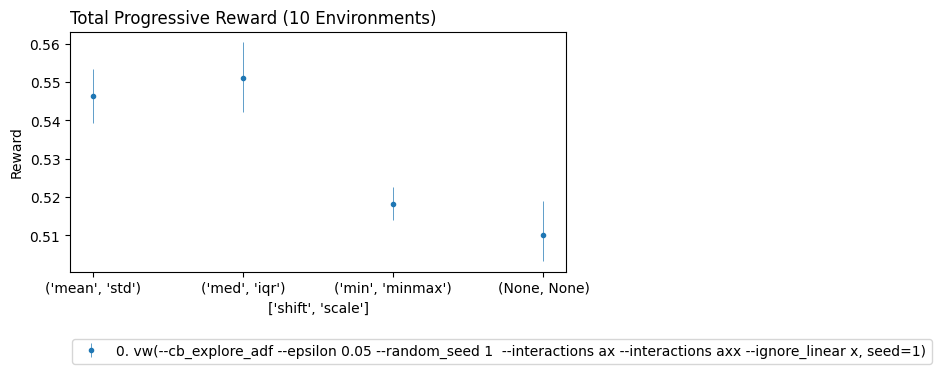

In [14]:
#This shows how to evaluate what scaling logic works for your environment
env = cb.Environments.from_openml(180, take=4000)
env = env + env.scale('min','minmax',using=2000) + env.scale('mean','std',using=2000) + env.scale('med','iqr')
env = env.shuffle(n=10)

lrn = cb.VowpalEpsilonLearner()

if False: #Make this true to run the experiment
    cb.Experiment(env,lrn).run(quiet=True,processes=10).plot_learners(x=['shift','scale'], err='bs')

Above we see that for this environment either standardizing or robust scaling the context features seems to give the best performance.


### Hyperparameter Tuning

Coba doesn't offer any out of the box methods like random search or halving.

Instead we rely primarily on experiment level paralellization to make explicit searches computationally viable.

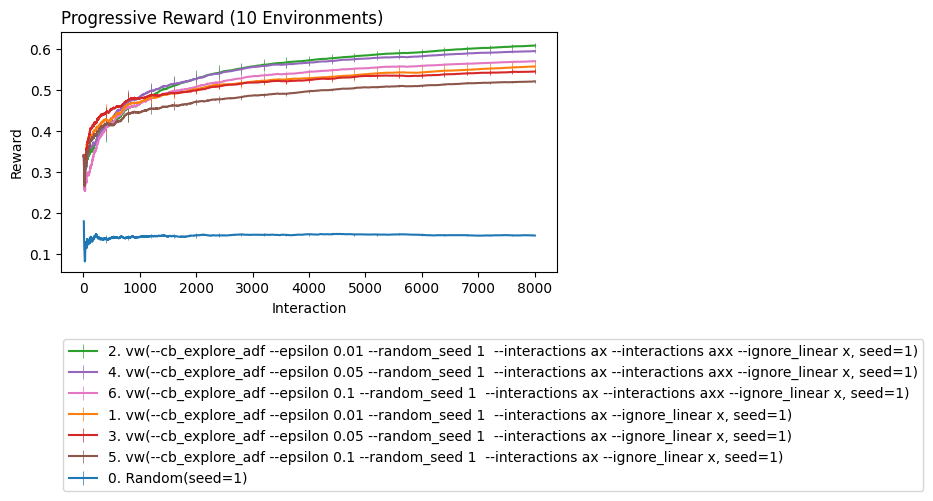

In [18]:
#This demonstrates how to do a hyperparameter sweep across VowpalEpsilonLearner

env = cb.Environments.from_openml(180, take=8000).scale('med','iqr').shuffle(n=10)

lrn = [cb.RandomLearner()]
for epsilon in [.01, .05, .1]:
    for feats in [(1,'a','ax'),(1,'a','ax','axx')]:
        lrn.append(cb.VowpalEpsilonLearner(epsilon=epsilon,features=feats))

if False: #Make this true to run the experiment
    cb.Experiment(env,lrn).run(quiet=True,processes=10).plot_learners(xlim=(10,None),err='bs')

### Robustness to Extreme Non-stationarity

The cycle shock we show below is an absolute worst case. Even so we see that our learner can be paramaterized in ways to be more robust.

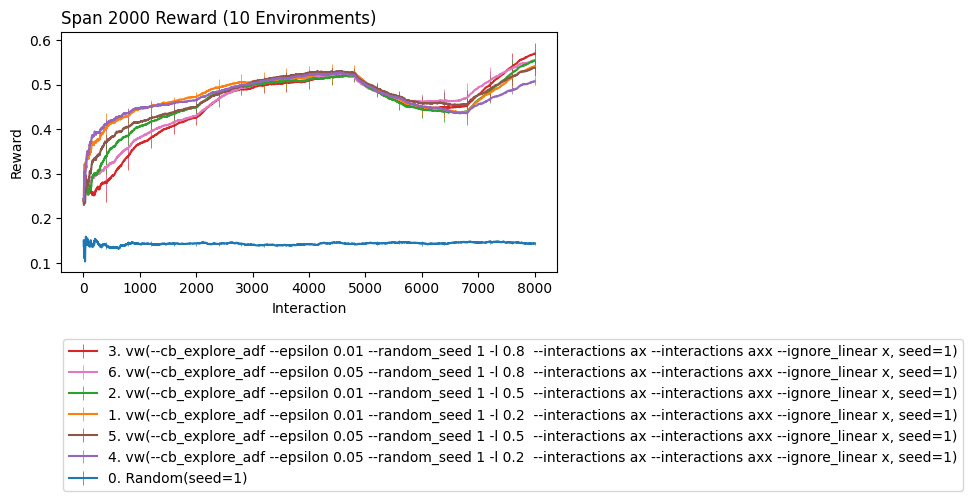

In [24]:
#This demonstrates how to do a hyperparameter sweep across VowpalEpsilonLearner

env = cb.Environments.from_openml(180, take=8000).scale('med','iqr').shuffle(n=10).cycle(after=4000).riffle(6)

lrn = [cb.RandomLearner()]
for epsilon in [.01, .05]:
    for feats in [(1,'a','ax','axx')]:
        lrn.append(cb.VowpalEpsilonLearner(epsilon=epsilon,features=feats,l=.2))
        lrn.append(cb.VowpalEpsilonLearner(epsilon=epsilon,features=feats,l=.5))
        lrn.append(cb.VowpalEpsilonLearner(epsilon=epsilon,features=feats,l=.8))

if False: #Make this true to run the experiment
    cb.Experiment(env,lrn).run(quiet=True,processes=10).plot_learners(xlim=(10,None),err='bs',span=2000)

## Running Experiments on Logged Data

Coba has considerable support for analysis using logged data. This is covered in detail in [Logged Bandit Data](Logged_Bandit_Data.ipynb).